# Purpose of this experiment
To comparing two cases of transformer  
1. with positional embedding
2. with rotary position encoding (following the paper [RoFomer: Enhanced Trasformer with Rotary Poisition Embedding](https://arxiv.org/abs/2104.09864))

**I look at how train/val loss behaves between the above cases.**


The model size is about couple million parameters, and tokens are character-based.     

# Model Preparation
As wonderful reference to codes, I used two resouces  
- [Transformer with positional embedding](https://www.youtube.com/watch?v=kCc8FmEb1nY&t=491s) by **Andrej Karpathy**
- [source code of Llama](https://github.com/meta-llama/llama/blob/main/llama/model.py#L207) for rotary position encoding
  - also, [nice video](https://www.youtube.com/watch?v=oM4VmoabDAI) by Umar Jamil


Basically, incorporated rotary position encoding in Andrej's code.

### Config

In [6]:
import torch

batch_size = 64
block_size = 256
max_iters = 10000
eval_interval = 500
learning_rate = 3e-4
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 384
n_head = 6
n_layer = 3
dropout = 0.2

### Data Preparation

In [7]:
import torch
import tensorflow as tf
path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')

chars = sorted(list(set(text)))
vocab_size = len(chars)

stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s]
decode = lambda l: ''.join([itos[i] for i in l])

data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data))
train_data = data[:n]
val_data = data[n:]

1115394/1115394 [==============================] - 1s 1us/step


### Utils

In [8]:
def get_batch(split):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss(model):
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

def start_training(model):
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

    train_loss, val_loss, iterations = [], [], []
    for iter in range(max_iters):

        if iter % eval_interval == 0 or iter == max_iters - 1:
            losses = estimate_loss(model)
            print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
            val_loss.append(losses['val'])
            train_loss.append(losses['train'])
            iterations.append(iter)

        xb, yb = get_batch('train')

        logits, loss = model(xb, yb)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
    return train_loss, val_loss, iterations

### Functions for Rotary Position Encoding

In [9]:
def precompute_theta_pos_frequencies(head_dim: int, seq_len: int, device:str, theta: float = 10000.0):
    assert head_dim % 2 == 0, "Dimension must be divisible by 2"
    theta_numerator = torch.arange(0, head_dim, 2).float()
    theta = 1.0 / (theta ** (theta_numerator / head_dim)).to(device)
    m = torch.arange(seq_len, device=device)
    freqs = torch.outer(m, theta).float()
    freqs_complex = torch.polar(torch.ones_like(freqs), freqs)
    return freqs_complex

def apply_rotary_embeddings(x: torch.Tensor, freqs_complex: torch.Tensor, device:str):
    x_complex = torch.view_as_complex(x.float().reshape(*x.shape[:-1], -1, 2))
    freqs_complex = freqs_complex.unsqueeze(0)
    freqs_complex = freqs_complex[:, :x.shape[1],:]
    x_rotated = x_complex * freqs_complex
    x_out = torch.view_as_real(x_rotated)
    x_out = x_out.reshape(*x.shape)
    return x_out.type_as(x).to(device)

### Transformer Encoder Model

In [10]:
import torch.nn as nn
from torch.nn import functional as F

class Head(nn.Module):

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, fc=None):
        B,T,C = x.shape

        k = self.key(x)
        q = self.query(x)
        v = self.value(x)

        if fc is not None:
          k = apply_rotary_embeddings(k, fc, device=device)
          q = apply_rotary_embeddings(q, fc, device=device)

        wei = q @ k.transpose(-2,-1) * C**-0.5
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)

        out = wei @ v
        return out

class MultiHeadAttention(nn.Module):

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, fc=None):
        out = torch.cat([h(x, fc=fc) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedForward(nn.Module):

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):

    def __init__(self, n_embd, n_head):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedForward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x, fc=None):
        x = x + self.sa(x, fc=fc)
        x = self.ln1(x)
        x = x + self.ffwd(x)
        x = self.ln2(x)
        return x

In [11]:
torch.manual_seed(1234)

class model(nn.Module):

    def __init__(self, use_pos_emb=False, use_rot_encoding=False):
        super().__init__()

        self.use_pos_emb = use_pos_emb
        self.use_rot_encoding = use_rot_encoding

        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd) if self.use_pos_emb else None

        head_size = n_embd // n_head
        self.blocks = nn.ModuleList()
        for layer_id in range(n_layer):
            self.blocks.append(Block(n_embd, n_head=n_head))

        self.lm_head = nn.Linear(n_embd, vocab_size)

        self.freqs_complex = precompute_theta_pos_frequencies(head_size, block_size, device=device) if self.use_rot_encoding else None

    def forward(self, idx, targets=None):
        B, T = idx.shape

        tok_emb = self.token_embedding_table(idx)

        x = tok_emb
        if self.use_pos_emb:
          pos_emb = self.position_embedding_table(torch.arange(T, device=device))
          x += pos_emb


        for block in self.blocks:
            x = block(x, self.freqs_complex)

        logits = self.lm_head(x)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape

            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)
        return logits, loss

    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -block_size:]
            logits, loss = self(idx_cond)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx

### Run with Rotary Positional Encoding

In [12]:
model_rot_encoding = model(use_pos_emb=False, use_rot_encoding=True).to(device)

train_loss_0, val_loss_0, iterations_0 = start_training(model_rot_encoding)

step 0: train loss 4.3206, val loss 4.3198
step 500: train loss 1.5605, val loss 1.7410
step 1000: train loss 1.4051, val loss 1.6163
step 1500: train loss 1.3304, val loss 1.5651
step 2000: train loss 1.2795, val loss 1.5338
step 2500: train loss 1.2405, val loss 1.5237
step 3000: train loss 1.2066, val loss 1.5070
step 3500: train loss 1.1762, val loss 1.4970
step 4000: train loss 1.1518, val loss 1.4966
step 4500: train loss 1.1251, val loss 1.4958
step 5000: train loss 1.1064, val loss 1.5074
step 5500: train loss 1.0832, val loss 1.5025
step 6000: train loss 1.0600, val loss 1.5114
step 6500: train loss 1.0366, val loss 1.5127
step 7000: train loss 1.0172, val loss 1.5269
step 7500: train loss 0.9983, val loss 1.5247
step 8000: train loss 0.9790, val loss 1.5316
step 8500: train loss 0.9614, val loss 1.5334
step 9000: train loss 0.9423, val loss 1.5533
step 9500: train loss 0.9265, val loss 1.5678
step 9999: train loss 0.9062, val loss 1.5686


In [17]:
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(model_rot_encoding.generate(idx=context, max_new_tokens=1000)[0].tolist()))


ROMEO:
Stake the directitude to be rain!

PETRUCHIO:
The benefit of my dear proph, ere were God!
O place, thy turn swift against those
Thanking thy sinews thusets, privil'd-royar,
Though for thy lenealce from mine enemy:
Thou, many corse; the truth to endure gound.

CLARENCE:
Sirrah, but to thy father's charge the palate!
Soft! for whoso followers shall not stand:
I will thy contrary forth of these dears?
Reads, lay.

BUCKINGHAM:
My lord, here consul is Surrey,
So Thursday Plantagenet. Lady: these will after:
Commend and noble king, the happy curse
I seen us in his reposed of a pushond fast.
Who dares for us? 'tis it become the cause.

Messenger:
Had slaid an oath nor guess
To make me, whisper so her army
Beauty senator: sits my needs wold, I she
And put it on me, that ever it, so cripely
Stand up good town so glir with your king.
Now, afre you log; not as if you stain,--
Were not are the went with the cobject,
For haltive stone posk without hearing sweet,
And that way thrive mine, wh

### Run with Positional Embedding

In [ ]:
model_pos_embed = model(use_pos_emb=True, use_rot_encoding=False).to(device)

train_loss_1, val_loss_1, iterations_1 = start_training(model_pos_embed)

step 0: train loss 4.3160, val loss 4.3229
step 500: train loss 2.0393, val loss 2.1087
step 1000: train loss 1.6545, val loss 1.8198
step 1500: train loss 1.5011, val loss 1.6945
step 2000: train loss 1.4194, val loss 1.6155
step 2500: train loss 1.3610, val loss 1.5876
step 3000: train loss 1.3222, val loss 1.5604
step 3500: train loss 1.2913, val loss 1.5477
step 4000: train loss 1.2571, val loss 1.5221
step 4500: train loss 1.2323, val loss 1.5090
step 5000: train loss 1.2095, val loss 1.5127
step 5500: train loss 1.1860, val loss 1.5026
step 6000: train loss 1.1693, val loss 1.4977
step 6500: train loss 1.1463, val loss 1.4992
step 7000: train loss 1.1305, val loss 1.4932
step 7500: train loss 1.1131, val loss 1.4859
step 8000: train loss 1.1010, val loss 1.4955
step 8500: train loss 1.0815, val loss 1.4997
step 9000: train loss 1.0664, val loss 1.4944
step 9500: train loss 1.0508, val loss 1.5014
step 9999: train loss 1.0370, val loss 1.5077


### Run without any positional information

In [ ]:
model_no_pos = model(use_pos_emb=False, use_rot_encoding=False).to(device)

train_loss_2, val_loss_2, iterations_2 = start_training(model_no_pos)

step 0: train loss 4.3432, val loss 4.3513
step 500: train loss 2.3217, val loss 2.3840
step 1000: train loss 2.0656, val loss 2.1862
step 1500: train loss 1.9222, val loss 2.0660
step 2000: train loss 1.8012, val loss 1.9656
step 2500: train loss 1.7424, val loss 1.9210
step 3000: train loss 1.7101, val loss 1.9069
step 3500: train loss 1.6573, val loss 1.8660
step 4000: train loss 1.6459, val loss 1.8592
step 4500: train loss 1.6120, val loss 1.8340
step 5000: train loss 1.5977, val loss 1.8253
step 5500: train loss 1.5721, val loss 1.8140
step 6000: train loss 1.5686, val loss 1.8049
step 6500: train loss 1.5597, val loss 1.8084
step 7000: train loss 1.5502, val loss 1.8059
step 7500: train loss 1.5462, val loss 1.8042
step 8000: train loss 1.5271, val loss 1.7907
step 8500: train loss 1.5185, val loss 1.7919
step 9000: train loss 1.5135, val loss 1.7911
step 9500: train loss 1.5029, val loss 1.7802
step 9999: train loss 1.4889, val loss 1.7767


In [ ]:
import pandas as pd

path = '/content/drive/MyDrive/'

for train, val, name in zip([train_loss_0, train_loss_1, train_loss_2],
                      [val_loss_0, val_loss_1, val_loss_2],
                      ['rotary_encoding', 'pos_embedding', 'none']):

  df = pd.DataFrame()
  df['steps'] = iterations_0
  df['train_loss'] = train
  df['val_loss'] = val
  df['train_loss'] = df['train_loss'].apply(lambda x:x.item())
  df['val_loss'] = df['val_loss'].apply(lambda x:x.item())

  df.to_csv(path+name + '_loss_evaluation.csv', index=False)

# Results

In [1]:
import pandas as pd

df_re = pd.read_csv('/content/drive/MyDrive/rotary_encoding_loss_evaluation.csv')
df_pe = pd.read_csv('/content/drive/MyDrive/pos_embedding_loss_evaluation.csv')
df_n = pd.read_csv('/content/drive/MyDrive/none_loss_evaluation.csv')

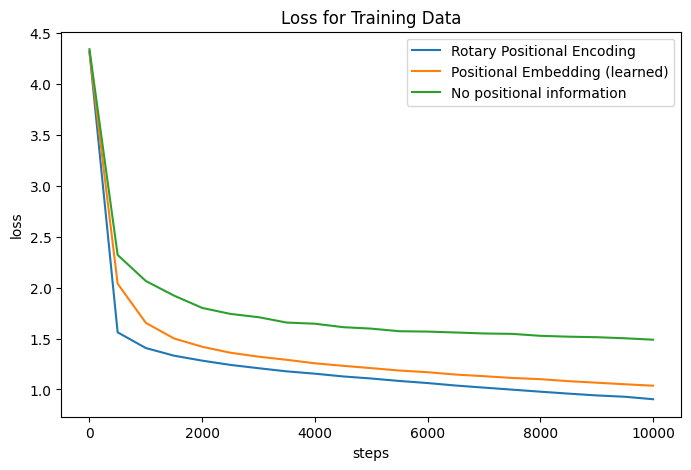

In [4]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(df_re['steps'], df_re['train_loss'], label='Rotary Positional Encoding')
ax.plot(df_pe['steps'], df_pe['train_loss'], label='Positional Embedding (learned)')
ax.plot(df_n['steps'], df_n['train_loss'], label='No positional information')
ax.set_title('Loss for Training Data')
ax.legend()
ax.set_xlabel('steps')
ax.set_ylabel('loss')
fig.savefig('training.png')

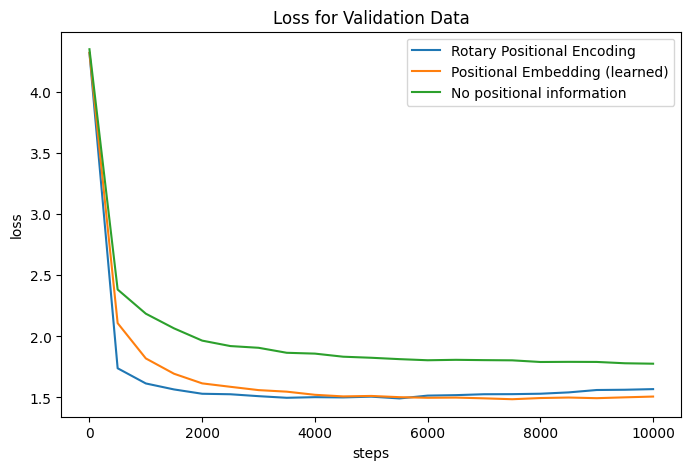

In [5]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(df_re['steps'], df_re['val_loss'], label='Rotary Positional Encoding')
ax.plot(df_pe['steps'], df_pe['val_loss'], label='Positional Embedding (learned)')
ax.plot(df_n['steps'], df_n['val_loss'], label='No positional information')
ax.set_title('Loss for Validation Data')
ax.legend()
ax.set_xlabel('steps')
ax.set_ylabel('loss')
fig.savefig('validation.png')